In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
image_size = 224

## Creating DataGenerator

In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                            shear_range = 0.2,
                                                            zoom_range = 0.2,
                                                            width_shift_range = 0.2,
                                                            height_shift_range = 0.2,
                                                            fill_mode="nearest")
batch_size = 32
train_data = train_datagen.flow_from_directory(os.path.join(base_dir,"train"),
                                               target_size=(image_size,image_size),
                                               batch_size=batch_size,
                                               class_mode="categorical"                                               
                                              )

Found 70295 images belonging to 38 classes.


In [4]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)
test_data = test_datagen.flow_from_directory(os.path.join(base_dir,"valid"),
                                               target_size=(image_size,image_size),
                                               batch_size=batch_size,
                                               class_mode="categorical"                                               
                                              )

Found 17572 images belonging to 38 classes.


In [5]:
categories = list(train_data.class_indices.keys())
print(categories)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [6]:
train_data.image_shape

(224, 224, 3)

## Using MobileNet

In [7]:
base_model = keras.applications.MobileNet(weights="imagenet",include_top=False,input_shape=(image_size,image_size,3))

17227776/17225924 [==============================] - 0s 0us/step


In [8]:

base_model.trainable = False
inputs = keras.Input(shape=(image_size,image_size,3))
x = base_model(inputs,training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(len(categories),activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=x, name="LeafDisease_MobileNet")

In [9]:
model.summary()

Model: "LeafDisease_MobileNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 38)                38950     
Total params: 3,267,814
Trainable params: 38,950
Non-trainable params: 3,228,864
_________________________________________________________________


In [10]:

optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=keras.losses.CategoricalCrossentropy(from_logits=True),metrics=[keras.metrics.CategoricalAccuracy()])

In [11]:
history = model.fit_generator(train_data,
          validation_data=test_data,
          epochs=25,
          steps_per_epoch=150,
          validation_steps=100
         )

Epoch 1/25
150/150 [==============================] - 76s 508ms/step - loss: 3.3871 - categorical_accuracy: 0.3537 - val_loss: 3.1294 - val_categorical_accuracy: 0.6316
Epoch 2/25
150/150 [==============================] - 75s 499ms/step - loss: 3.0812 - categorical_accuracy: 0.6665 - val_loss: 2.9800 - val_categorical_accuracy: 0.7475
Epoch 3/25
150/150 [==============================] - 74s 491ms/step - loss: 2.9754 - categorical_accuracy: 0.7594 - val_loss: 2.9094 - val_categorical_accuracy: 0.8225
Epoch 4/25
150/150 [==============================] - 73s 489ms/step - loss: 2.9158 - categorical_accuracy: 0.8127 - val_loss: 2.8913 - val_categorical_accuracy: 0.8184
Epoch 5/25
150/150 [==============================] - 72s 478ms/step - loss: 2.9008 - categorical_accuracy: 0.8171 - val_loss: 2.8631 - val_categorical_accuracy: 0.8453
Epoch 6/25
150/150 [==============================] - 71s 474ms/step - loss: 2.8926 - categorical_accuracy: 0.8231 - val_loss: 2.8696 - val_categorical_acc

In [12]:
model.evaluate(test_data)

550/550 [==============================] - 46s 83ms/step - loss: 2.7734 - categorical_accuracy: 0.9211


[2.773350477218628, 0.9210675954818726]

In [13]:
model.save('leaf-cnn.h5')

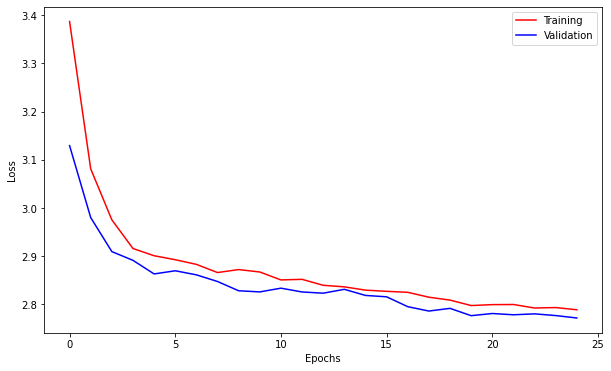

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

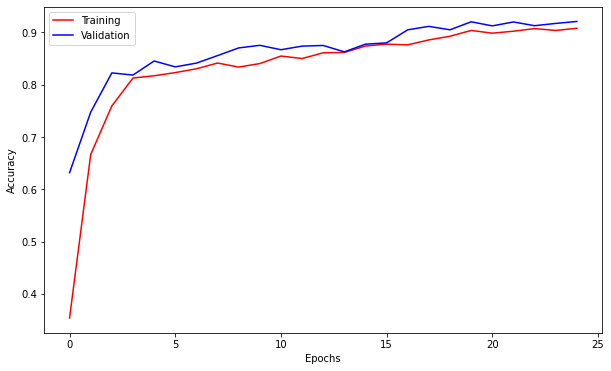

In [15]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()